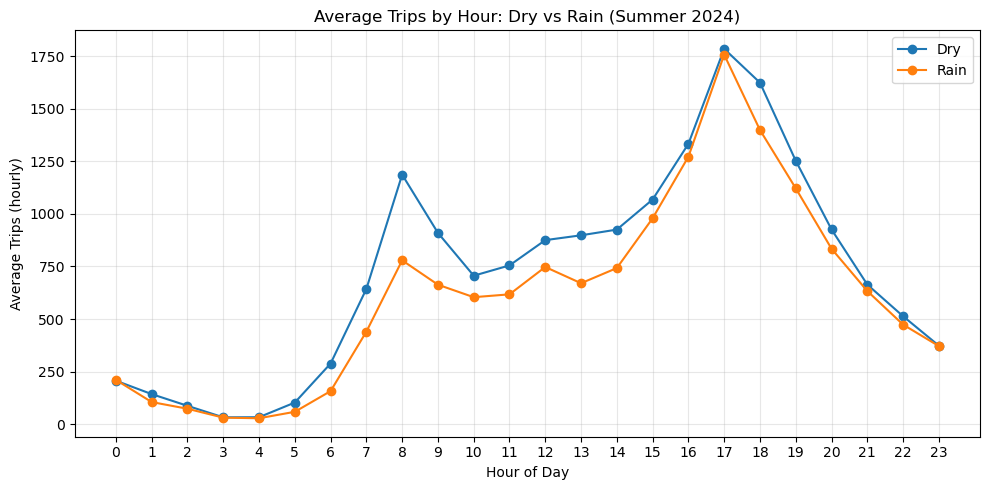

      pct_change_rain_vs_dry
hour                        
0                       1.83
1                     -26.43
2                     -15.92
3                      -4.73
4                     -14.78
5                     -42.74
6                     -45.45
7                     -31.57
8                     -34.33
9                     -27.08
10                    -14.46
11                    -18.22
12                    -14.59
13                    -25.37
14                    -19.76
15                     -8.35
16                     -4.60
17                     -1.56
18                    -13.86
19                    -10.46
20                     -9.90
21                     -4.61
22                     -7.77
23                     -0.50


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df_hourly.copy()

p = "w_total_precipitation"  # change to w_total_precipitation_mm if you created it
thr = 0.1  # mm/hr-style threshold (adjust if your units differ)

df["hour"] = pd.to_datetime(df["hour_ts"]).dt.hour
df["is_rain"] = df[p].fillna(0) > thr

g = (
    df.groupby(["hour", "is_rain"])["trips"]
      .mean()
      .reset_index()
      .pivot(index="hour", columns="is_rain", values="trips")
      .rename(columns={False: "Dry", True: "Rain"})
)

plt.figure(figsize=(10, 5))
plt.plot(g.index, g["Dry"], marker="o", label="Dry")
plt.plot(g.index, g["Rain"], marker="o", label="Rain")
plt.xticks(range(0, 24))
plt.xlabel("Hour of Day")
plt.ylabel("Average Trips (hourly)")
plt.title("Average Trips by Hour: Dry vs Rain (Summer 2024)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# optional: table of % difference by hour
pct = ((g["Rain"] / g["Dry"]) - 1) * 100
print(pd.DataFrame({"pct_change_rain_vs_dry": pct}).round(2))

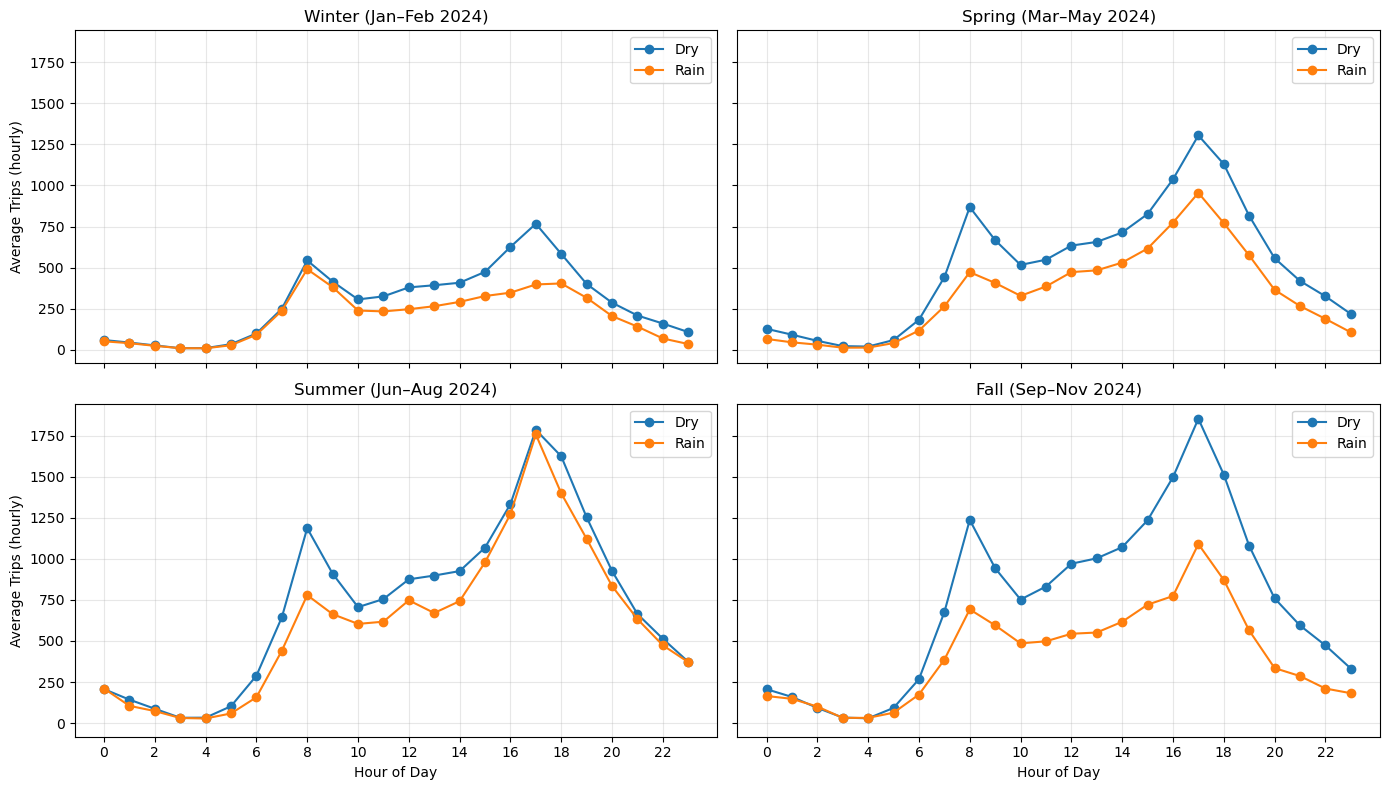

In [26]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

weather_cols = [
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "2m_dewpoint_temperature",
    "2m_temperature",
    "instantaneous_10m_wind_gust",
    "precipitation_type",
    "snow_depth",
    "snowfall",
    "surface_pressure",
    "surface_solar_radiation_downwards",
    "surface_thermal_radiation_downwards",
    "total_cloud_cover",
    "total_precipitation",
    "wind_speed",
    "wind_direction",
    "relative_humidity",
]
alias = {c: f"w_{c}" for c in weather_cols}
avg_exprs = ",\n  ".join([f'AVG("{c}") AS {alias[c]}' for c in weather_cols])

p = alias["total_precipitation"]   # precip column after aliasing
thr = 0.1                          # adjust if your units differ

seasons_2024 = [
    ("Winter (Jan–Feb 2024)", "2024-01-01", "2024-03-01"),
    ("Spring (Mar–May 2024)", "2024-03-01", "2024-06-01"),
    ("Summer (Jun–Aug 2024)", "2024-06-01", "2024-09-01"),
    ("Fall (Sep–Nov 2024)",   "2024-09-01", "2024-12-01"),
]

def load_hourly(con, start, end):
    return con.execute(f"""
        SELECT
          date_trunc('hour', weather_time) AS hour_ts,
          COUNT(*) AS trips,
          {avg_exprs}
        FROM trips_weather_interpolated
        WHERE weather_time >= TIMESTAMP '{start}'
          AND weather_time <  TIMESTAMP '{end}'
        GROUP BY 1
        ORDER BY 1
    """).df()

con = duckdb.connect("bluebikes_2015_2025.duckdb")

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (title, start, end) in zip(axes, seasons_2024):
    df = load_hourly(con, start, end)
    df["hour"] = pd.to_datetime(df["hour_ts"]).dt.hour
    df["is_rain"] = df[p].fillna(0) > thr

    g = (
        df.groupby(["hour", "is_rain"])["trips"]
          .mean()
          .reset_index()
          .pivot(index="hour", columns="is_rain", values="trips")
          .rename(columns={False: "Dry", True: "Rain"})
          .reindex(range(24))
    )

    ax.plot(g.index, g.get("Dry"), marker="o", label="Dry")
    ax.plot(g.index, g.get("Rain"), marker="o", label="Rain")
    ax.set_title(title)
    ax.set_xticks(range(0, 24, 2))
    ax.grid(True, alpha=0.3)

con.close()

axes[0].set_ylabel("Average Trips (hourly)")
axes[2].set_ylabel("Average Trips (hourly)")
axes[2].set_xlabel("Hour of Day")
axes[3].set_xlabel("Hour of Day")
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

plt.tight_layout()
plt.show()

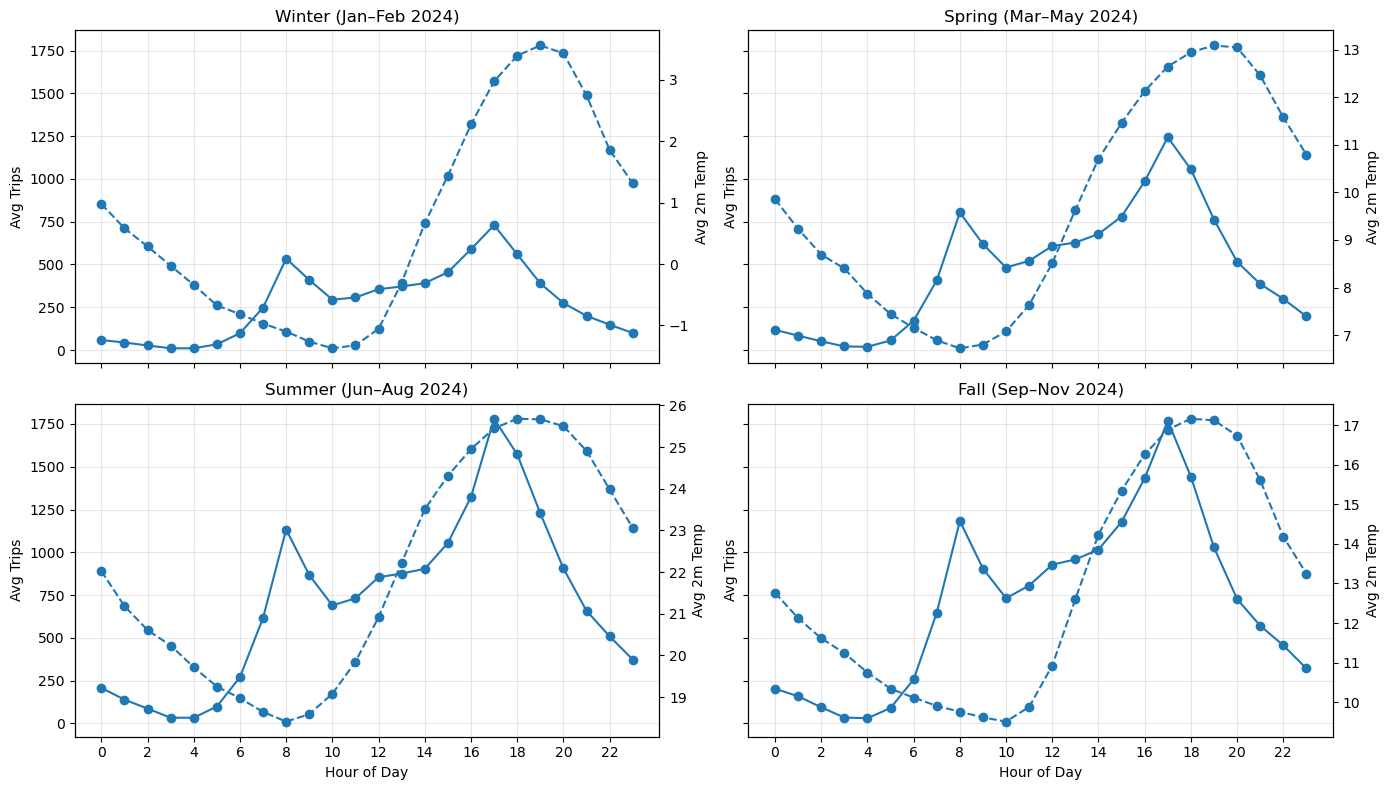

In [16]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

weather_cols = [
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "2m_dewpoint_temperature",
    "2m_temperature",
    "instantaneous_10m_wind_gust",
    "precipitation_type",
    "snow_depth",
    "snowfall",
    "surface_pressure",
    "surface_solar_radiation_downwards",
    "surface_thermal_radiation_downwards",
    "total_cloud_cover",
    "total_precipitation",
    "wind_speed",
    "wind_direction",
    "relative_humidity",
]
alias = {c: f"w_{c}" for c in weather_cols}
avg_exprs = ",\n  ".join([f'AVG("{c}") AS {alias[c]}' for c in weather_cols])

temp_col = alias["2m_temperature"]

seasons_2024 = [
    ("Winter (Jan–Feb 2024)", "2024-01-01", "2024-03-01"),
    ("Spring (Mar–May 2024)", "2024-03-01", "2024-06-01"),
    ("Summer (Jun–Aug 2024)", "2024-06-01", "2024-09-01"),
    ("Fall (Sep–Nov 2024)",   "2024-09-01", "2024-12-01"),
]

def load_hourly(con, start, end):
    return con.execute(f"""
        SELECT
          date_trunc('hour', weather_time) AS hour_ts,
          COUNT(*) AS trips,
          {avg_exprs}
        FROM trips_weather_interpolated
        WHERE weather_time >= TIMESTAMP '{start}'
          AND weather_time <  TIMESTAMP '{end}'
        GROUP BY 1
        ORDER BY 1
    """).df()

con = duckdb.connect("bluebikes_2015_2025.duckdb")

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (title, start, end) in zip(axes, seasons_2024):
    df = load_hourly(con, start, end)
    df["hour"] = pd.to_datetime(df["hour_ts"]).dt.hour

    g = (
        df.groupby("hour")[["trips", temp_col]]
          .mean()
          .reindex(range(24))
    )

    ax.plot(g.index, g["trips"], marker="o", label="Trips")
    ax2 = ax.twinx()
    ax2.plot(g.index, g[temp_col], marker="o", linestyle="--", label="2m Temp")

    ax.set_title(title)
    ax.set_xticks(range(0, 24, 2))
    ax.grid(True, alpha=0.3)

    ax.set_ylabel("Avg Trips")
    ax2.set_ylabel("Avg 2m Temp")

con.close()

axes[2].set_xlabel("Hour of Day")
axes[3].set_xlabel("Hour of Day")

plt.tight_layout()
plt.show()

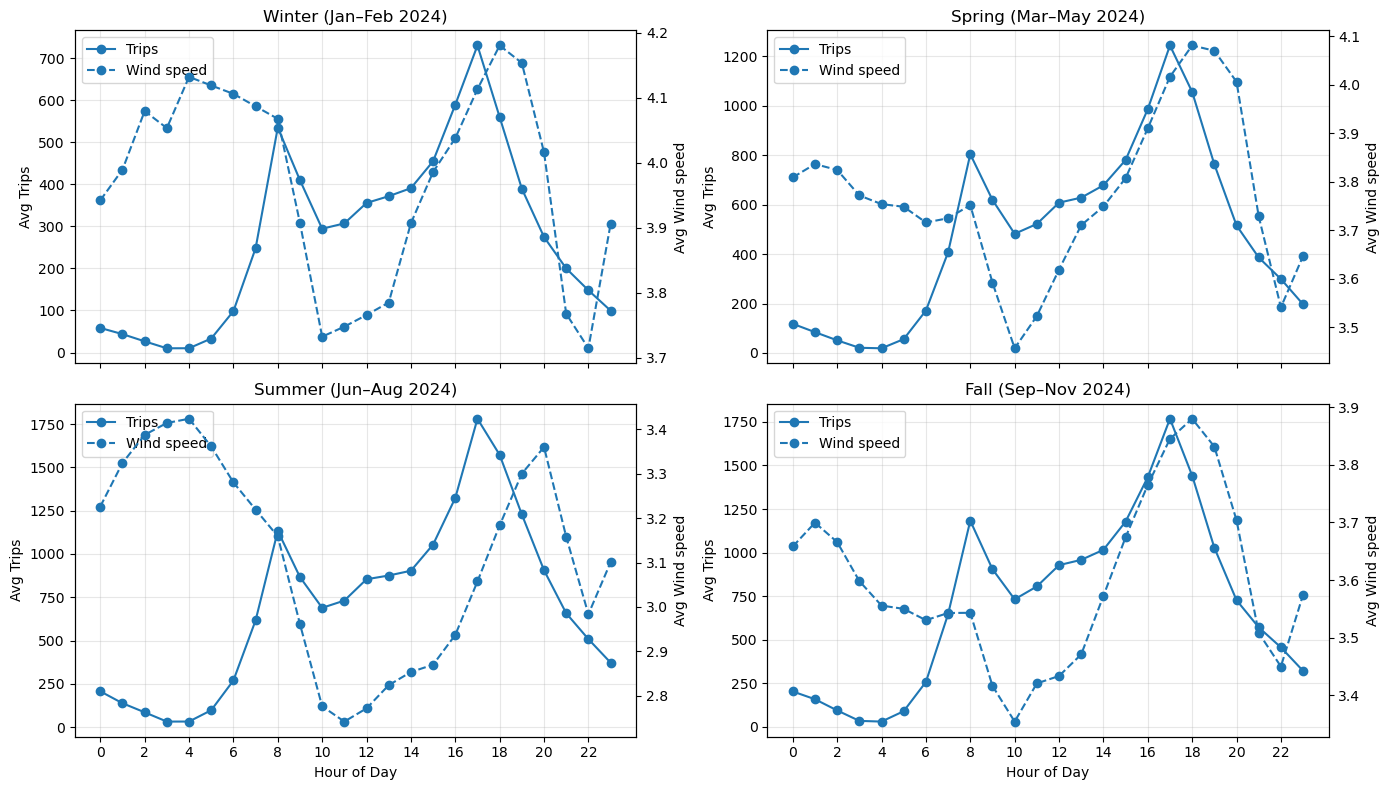

In [17]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

weather_cols = [
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "2m_dewpoint_temperature",
    "2m_temperature",
    "instantaneous_10m_wind_gust",
    "precipitation_type",
    "snow_depth",
    "snowfall",
    "surface_pressure",
    "surface_solar_radiation_downwards",
    "surface_thermal_radiation_downwards",
    "total_cloud_cover",
    "total_precipitation",
    "wind_speed",
    "wind_direction",
    "relative_humidity",
]
alias = {c: f"w_{c}" for c in weather_cols}
avg_exprs = ",\n  ".join([f'AVG("{c}") AS {alias[c]}' for c in weather_cols])

wind_col = alias["wind_speed"]

seasons_2024 = [
    ("Winter (Jan–Feb 2024)", "2024-01-01", "2024-03-01"),
    ("Spring (Mar–May 2024)", "2024-03-01", "2024-06-01"),
    ("Summer (Jun–Aug 2024)", "2024-06-01", "2024-09-01"),
    ("Fall (Sep–Nov 2024)",   "2024-09-01", "2024-12-01"),
]

def load_hourly(con, start, end):
    return con.execute(f"""
        SELECT
          date_trunc('hour', weather_time) AS hour_ts,
          COUNT(*) AS trips,
          {avg_exprs}
        FROM trips_weather_interpolated
        WHERE weather_time >= TIMESTAMP '{start}'
          AND weather_time <  TIMESTAMP '{end}'
        GROUP BY 1
        ORDER BY 1
    """).df()

con = duckdb.connect("bluebikes_2015_2025.duckdb")

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
axes = axes.ravel()

for ax, (title, start, end) in zip(axes, seasons_2024):
    df = load_hourly(con, start, end)
    df["hour"] = pd.to_datetime(df["hour_ts"]).dt.hour

    g = (
        df.groupby("hour")[["trips", wind_col]]
          .mean()
          .reindex(range(24))
    )

    l1 = ax.plot(g.index, g["trips"], marker="o", label="Trips")
    ax2 = ax.twinx()
    l2 = ax2.plot(g.index, g[wind_col], marker="o", linestyle="--", label="Wind speed")

    ax.set_title(title)
    ax.set_xticks(range(0, 24, 2))
    ax.grid(True, alpha=0.3)
    ax.set_ylabel("Avg Trips")
    ax2.set_ylabel("Avg Wind speed")

    lines = l1 + l2
    labels = [ln.get_label() for ln in lines]
    ax.legend(lines, labels, loc="upper left")

con.close()

axes[2].set_xlabel("Hour of Day")
axes[3].set_xlabel("Hour of Day")

plt.tight_layout()
plt.show()


In [60]:
import duckdb
import pandas as pd

DB_PATH = "bluebikes_2015_2025.duckdb"
TABLE = "trips_weather_interpolated"

weather_cols = [
    "2m_dewpoint_temperature",
    "2m_temperature",
    "instantaneous_10m_wind_gust",
    "precipitation_type",
    "total_cloud_cover",
    "total_precipitation",
    "wind_speed",
    "wind_direction",
    "relative_humidity",
]

# Human-readable labels for weather variables
weather_labels = {
    "2m_dewpoint_temperature": "Dew Point (2m, °C)",
    "2m_temperature": "Air Temperature (2m, °C)",
    "instantaneous_10m_wind_gust": "Wind Gust (10m, m/s)",
    "precipitation_type": "Precipitation Type (code)",
    "total_cloud_cover": "Total Cloud Cover (%)",
    "total_precipitation": "Total Precipitation (mm)",
    "wind_speed": "Wind Speed (10m, m/s)",
    "wind_direction": "Wind Direction (°)",
    "relative_humidity": "Relative Humidity (%)",
}

con = duckdb.connect(DB_PATH)

# --- get column list and choose time column ---
all_cols = con.execute(f"PRAGMA table_info('{TABLE}')").df()["name"].tolist()
time_col = "weather_time" if "weather_time" in all_cols else "started_at"

# =========================
# Matrix 1
# =========================
df_summary1 = con.execute(f"""
WITH
trip_lat AS (
  SELECT CAST(start_lat AS DOUBLE) AS lat FROM {TABLE}
  UNION ALL
  SELECT CAST(end_lat   AS DOUBLE) AS lat FROM {TABLE}
),
trip_lon AS (
  SELECT CAST(start_lng AS DOUBLE) AS lon FROM {TABLE}
  UNION ALL
  SELECT CAST(end_lng   AS DOUBLE) AS lon FROM {TABLE}
),
valid_trip_lat AS (SELECT lat FROM trip_lat WHERE lat BETWEEN -90 AND 90),
valid_trip_lon AS (SELECT lon FROM trip_lon WHERE lon BETWEEN -180 AND 180),
valid_weather_lat AS (
  SELECT CAST(weather_lat AS DOUBLE) AS lat
  FROM {TABLE}
  WHERE weather_lat BETWEEN -90 AND 90
),
valid_weather_lon AS (
  SELECT CAST(weather_lon AS DOUBLE) AS lon
  FROM {TABLE}
  WHERE weather_lon BETWEEN -180 AND 180
)
SELECT
  COUNT(*) AS trips_count,
  MIN({time_col}) AS min_date,
  MAX({time_col}) AS max_date,

  (SELECT MIN(lat) FROM valid_trip_lat) AS min_trip_lat,
  (SELECT MAX(lat) FROM valid_trip_lat) AS max_trip_lat,
  (SELECT MIN(lon) FROM valid_trip_lon) AS min_trip_lon,
  (SELECT MAX(lon) FROM valid_trip_lon) AS max_trip_lon,

  (SELECT MIN(lat) FROM valid_weather_lat) AS min_weather_lat,
  (SELECT MAX(lat) FROM valid_weather_lat) AS max_weather_lat,
  (SELECT MIN(lon) FROM valid_weather_lon) AS min_weather_lon,
  (SELECT MAX(lon) FROM valid_weather_lon) AS max_weather_lon
FROM {TABLE};
""").df()

# Rename Matrix 1 columns (human-readable)
df_summary1 = df_summary1.rename(columns={
    "trips_count": "Trips (count)",
    "min_date": "Start date (min)",
    "max_date": "End date (max)",
    "min_trip_lat": "Trip latitude (min)",
    "max_trip_lat": "Trip latitude (max)",
    "min_trip_lon": "Trip longitude (min)",
    "max_trip_lon": "Trip longitude (max)",
    "min_weather_lat": "Weather grid latitude (min)",
    "max_weather_lat": "Weather grid latitude (max)",
    "min_weather_lon": "Weather grid longitude (min)",
    "max_weather_lon": "Weather grid longitude (max)",
})

# =========================
# Matrix 2: Weather stats (Aug 2024 -- Aug 2025)
# =========================
start_ts = "2024-08-01"
end_ts   = "2025-09-01"  # exclusive end (covers all Aug 2025)

existing_weather_cols = [c for c in weather_cols if c in all_cols]

weather_union = "\nUNION ALL\n".join([
    f"""
    SELECT
      '{c}' AS variable,
      MAX(CAST("{c}" AS DOUBLE)) AS max,
      MIN(CAST("{c}" AS DOUBLE)) AS min,
      AVG(CAST("{c}" AS DOUBLE)) AS avg,
      MEDIAN(CAST("{c}" AS DOUBLE)) AS median,
      QUANTILE_CONT(CAST("{c}" AS DOUBLE), 0.25) AS p25,
      QUANTILE_CONT(CAST("{c}" AS DOUBLE), 0.50) AS p50,
      QUANTILE_CONT(CAST("{c}" AS DOUBLE), 0.75) AS p75
    FROM {TABLE}
    WHERE {time_col} >= TIMESTAMP '{start_ts}'
      AND {time_col} <  TIMESTAMP '{end_ts}'
    """
    for c in existing_weather_cols
])

df_summary2 = con.execute(weather_union + "\nORDER BY variable;").df()
con.close()

# Rename Matrix 2 columns (human-readable)
df_summary2 = df_summary2.rename(columns={
    "variable": "Weather variable",
    "min": "Min",
    "max": "Max",
    "avg": "Average",
    "median": "Median",
    "p25": "P25",
    "p50": "P50",
    "p75": "P75",
})

# Replace variable codes with human labels
df_summary2["Weather variable"] = df_summary2["Weather variable"].map(weather_labels).fillna(df_summary2["Weather variable"])

In [68]:
d = df_summary1.round(2)
d.T.to_csv('df_summary1.csv')
d.T

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [65]:
d = df_summary2.round(2)
d.drop(columns=["P25", "P50", "P75"], inplace=True)
d.to_csv('df_summary2.csv', index=False)
d

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [55]:
con = duckdb.connect("bluebikes_2015_2025.duckdb")
df = con.execute("""
    SELECT *
    FROM trips_weather_interpolated
    WHERE weather_time >= '2015-01-01'
      AND weather_time <  '2015-03-01';
  """).df()
con.close()
df.describe()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11856 entries, 0 to 11855
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   _id                                  11856 non-null  int64         
 1   ride_id                              11856 non-null  object        
 2   rideable_type                        0 non-null      category      
 3   started_at                           11856 non-null  datetime64[ns]
 4   ended_at                             11856 non-null  datetime64[ns]
 5   start_station_name                   11856 non-null  object        
 6   start_station_id                     11856 non-null  object        
 7   end_station_name                     11856 non-null  object        
 8   end_station_id                       11856 non-null  object        
 9   start_lat                            11856 non-null  float64       
 10  start_lng 